# Setup

#### Load Packages

In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

# add parent directory to path
import sys
sys.path.append('..')

# import packages
import numpy as np
import matplotlib.pyplot as plt
import time

# import modules
import LimitedCommitmentModel as lmc
from figures import *
from checks import *

#### Compile C++ files

In [2]:
# compile c++ files
model = lmc.HouseholdModelClass(par={'num_Ctot':100})
try:
    model.link_to_cpp(force_compile=True)
except:
    model.cpp.delink()
    model.link_to_cpp(force_compile=True)

In [3]:
type(model)

LimitedCommitmentModel.HouseholdModelClass

In [4]:
for i in model.sol.Vm_single_to_couple.shape:
    print(i)

10
21
41
50


## User Settings

#### Specify Models

In [22]:
# Default settings
do_simulate = True
do_load     = False
do_save     = False

baseline_settings = {
    # Number of periods
    'T': 10,
    
    # Technical settings
    'threads': 50,
    'do_egm': True,
    # # 'num_love': 41,
    # # 'num_power': 41,
    # # 'num_A': 150,
    # # 'centered_gradient': True,
    # # 'interp_inverse': True,
    
    # # Numerical settings
    
    # # Parameters
    'sigma_love': 0.1,
    'p_meet': 0.2,
    
    # # Simulation
    'init_A': 1.0,
    'init_love': 0.0,
    'init_power_idx': 1,
    
}

# Model settings
specs = {
        
    'Baseline':    
        {'latexname':'Baseline', 
         'load': do_load,
         'save': do_save,
         'par':{**baseline_settings,
                }
        },
        
    'Unequal Asset Split':    
        {'latexname':'Div_A_share = 0.3', 
         'load': do_load,
         'save': do_save,
         'par':{**baseline_settings,
                'div_A_share': 0.23,
                }
        },
        
    'Deterministic Love':    
        {'latexname':'$\sigma = 0$', 
         'load': do_load,
         'save': do_save,
         'par':{**baseline_settings,
                'sigma_love': 0.0,
                }
        },
}

## Run models

#### Overview

In [23]:
# Make table
print_specs_table(specs)

                   |      Baseline     |Unequal Asset Split| Deterministic Love|
--------------------------------------------------------------------------------
T                  |         10        |         10        |         10        |
init_power_idx     |         1         |         1         |         1         |
sigma_love         |        0.1        |        0.1        |        0.0        |
p_meet             |        0.2        |        0.2        |        0.2        |
do_egm             |        True       |        True       |        True       |
init_love          |        0.0        |        0.0        |        0.0        |
threads            |         50        |         50        |         50        |
init_A             |        1.0        |        1.0        |        1.0        |
div_A_share        |        0.5        |        0.23       |        0.5        |


#### Solve/Load models

In [24]:
name ='Baseline'

model = lmc.HouseholdModelClass(name=name, par=specs[name]['par'], load=do_load)
model.link_to_cpp(force_compile=False)

In [25]:
# solve different models
models = {}
for name,spec in specs.items():
        #unpack
        par = spec['par']
        do_load = spec['load']
        do_save = spec['save']
        
        if do_load:
            print(f'loading {name}...')
        else:
            print(f'running {name}...')
        
        # setup model
        models[name] = lmc.HouseholdModelClass(name=name, par=spec['par'], load=do_load)
        models[name].spec = spec
        
        # link to cpp
        try:
            models[name].link_to_cpp(force_compile=False)
        except:
            models[name].cpp.delink()
            models[name].link_to_cpp(force_compile=False)
        
        # solve and simulate
        if not do_load:
            # solve
            time0 = time.time()
            models[name].solve()
            solution_time = time.time()-time0
            models[name].sol.solution_time[0] = solution_time
            
            #simulate
            if do_simulate:
                models[name].simulate()
        
        # save model
        if do_save:
            models[name].save()
        
# Save model names
model_names  = list(models.keys())

running Baseline...
running Unequal Asset Split...
running Deterministic Love...


In [26]:
models['Baseline'].par.simT

10

#### Speed

In [27]:
for name in model_names:
    solution_time = models[name].sol.solution_time
    minutes, seconds = divmod(solution_time, 60)
    seconds, ms      = divmod(seconds*100, 100)
    print(f"{name:16}: {int(minutes):2} minutes, {int(seconds):2} seconds, {int(ms):2} ms")


Baseline        :  0 minutes,  0 seconds, 31 ms
Unequal Asset Split:  0 minutes,  0 seconds, 32 ms
Deterministic Love:  0 minutes,  0 seconds, 17 ms


Groups of variables

In [28]:
def getVariablesWith(*args: str, no: list = None, model = model):
    return [var for var in list(model.sol.__dict__.keys()) if all(words in var for words in args) and (no is None or all(words not in var for words in no))]

Cw_priv = getVariablesWith('Cw_priv_')
Cm_priv = getVariablesWith('Cm_priv_')
Cw_single = getVariablesWith('Cw', 'to_single', no=['tot'])
Cm_single = getVariablesWith('Cw', 'to_single', no=['tot'])
C_couple = getVariablesWith('C', 'to_couple', no=['tot'])
EmargV = getVariablesWith('EmargV')
Vw = getVariablesWith('Vw', no=['marg','vec'])
Vm = getVariablesWith('Vm', no=['marg','vec'])

# Figures

In [29]:
# Choose index
t  = 9
iP = 10
iL = 20
iA = 10
idx = (t,iP,iL,iA)

# group of indexes
idx_low = (t,iP-8,iL,iA)
idx_high = (t,iP+8,iL,iA)

indexes = {   '$\mu_{t-1}='+f'{models[model_names[0]].par.grid_power[idx_low[1]]:2.2f}$':idx_low,
              '$\mu_{t-1}=0.50$': idx, 
              '$\mu_{t-1}='+f'{models[model_names[0]].par.grid_power[idx_high[1]]:2.2f}$': idx_high}


print(f"Time  : {t} / {models[model_names[0]].par.T-1}")
print(f"Power : {models[model_names[0]].par.grid_power[iP]}")
print(f"Love  : {models[model_names[0]].par.grid_love[iL]}")
print(f"Assets: {models[model_names[0]].par.grid_A[iA]}")

Time  : 9 / 9
Power : 0.5
Love  : 0.0
Assets: 2.1628104115028775


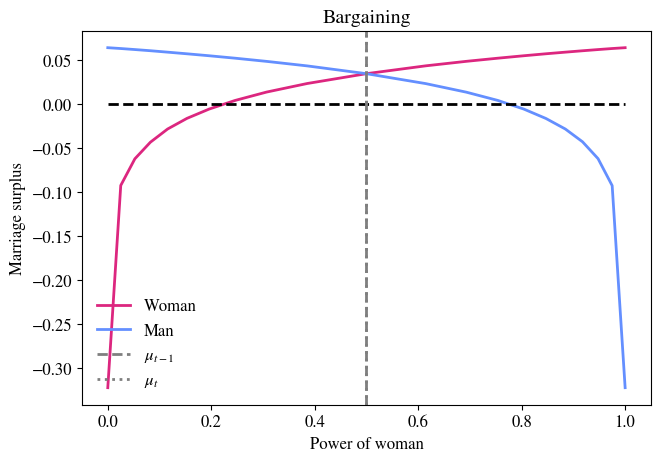

In [30]:
# Choose model
model = models['Deterministic Love']

# Choose variables
variables = {"Bargaining"        : "placeholder",}

# Plot
plotter = ModelPlot('variables', model, variables, idx)
plotter.plot_using(plot_surplus)

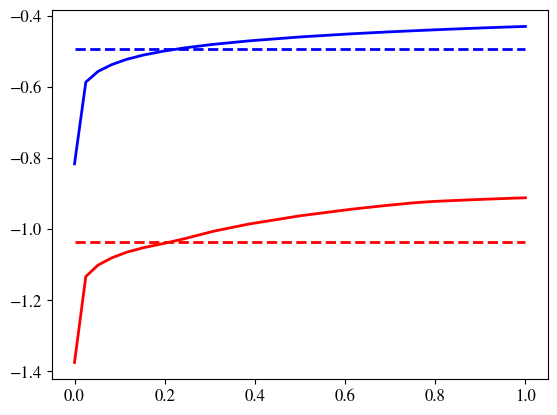

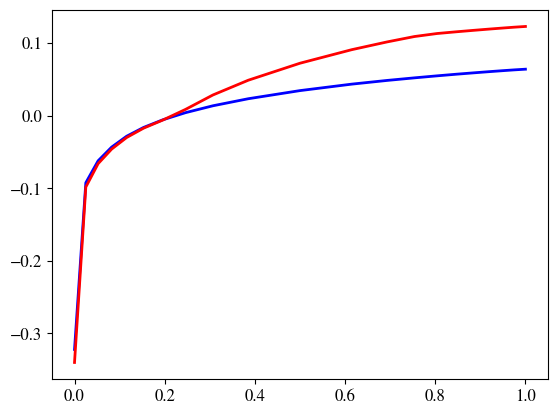

In [31]:
fig,ax = plt.subplots()
ax.plot(model.par.grid_power,model.sol.Vw_couple_to_couple[t,:,iL,iA],color='blue')
ax.plot(model.par.grid_power,model.sol.Vw_couple_to_couple[t-1,:,iL,iA],color='red')

ax.plot(model.par.grid_power,np.ones(model.par.grid_power.size)*model.sol.Vw_couple_to_single[t,iA],color='blue',linestyle='--')
ax.plot(model.par.grid_power,np.ones(model.par.grid_power.size)*model.sol.Vw_couple_to_single[t-1,iA],color='red',linestyle='--')

fig,ax = plt.subplots()
ax.plot(model.par.grid_power,model.sol.Vw_couple_to_couple[t,:,iL,iA]-model.sol.Vw_couple_to_single[t,iA],color='blue')
ax.plot(model.par.grid_power,model.sol.Vw_couple_to_couple[t-1,:,iL,iA]-model.sol.Vw_couple_to_single[t-1,iA],color='red')

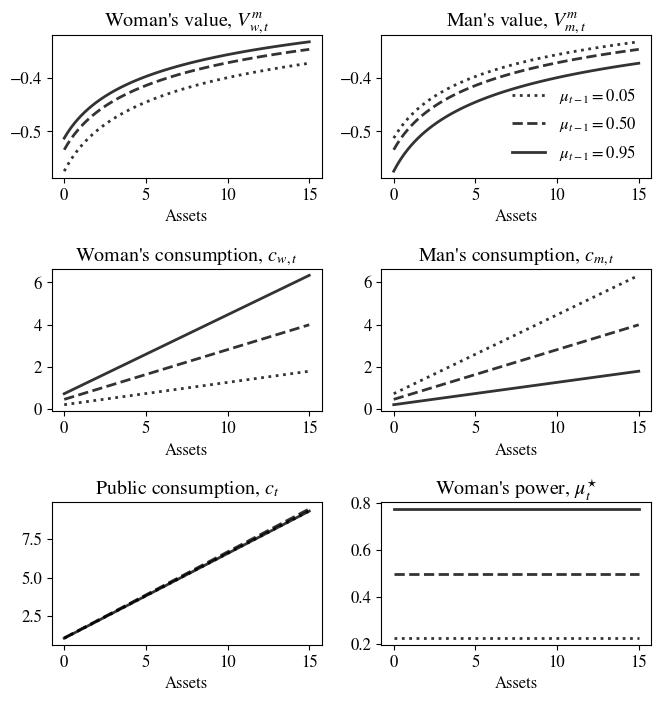

In [32]:
# Choose model

# Choose variables
variables = {r"Woman's value, $V_{w,t}^{m}$"        : "Vw_start_as_couple",
             r"Man's value, $V_{m,t}^{m}$"          : "Vm_start_as_couple", 
             r"Woman's consumption, $c_{w,t}$"  : "Cw_priv_start_as_couple", 
             r"Man's consumption, $c_{m,t}$"    : "Cm_priv_start_as_couple", 
             r"Public consumption, $c_{t}$"   : "C_pub_start_as_couple", 
             r"Woman's power, $\mu_t^{\star}$"        : "power"}

# Plot
colors = 'black'
linestyles = [':', '--', '-']
y_grid = [(-0.6 -0.02,-0.3 + 0.02)] * 2 + [(0 -0.5,10 +0.5)] * 3 +[(-0.05,1.05)]
y_grid = None 

plotter = ModelPlot('variables', models, variables, indexes, size='A4')
plotter.plot_using(plot_var_over_assets, models = models['Baseline'], save_as='', colors=colors, linestyles=linestyles, y_grid=y_grid, subplot_legends=1, subplot_settings={'alpha':0.8})

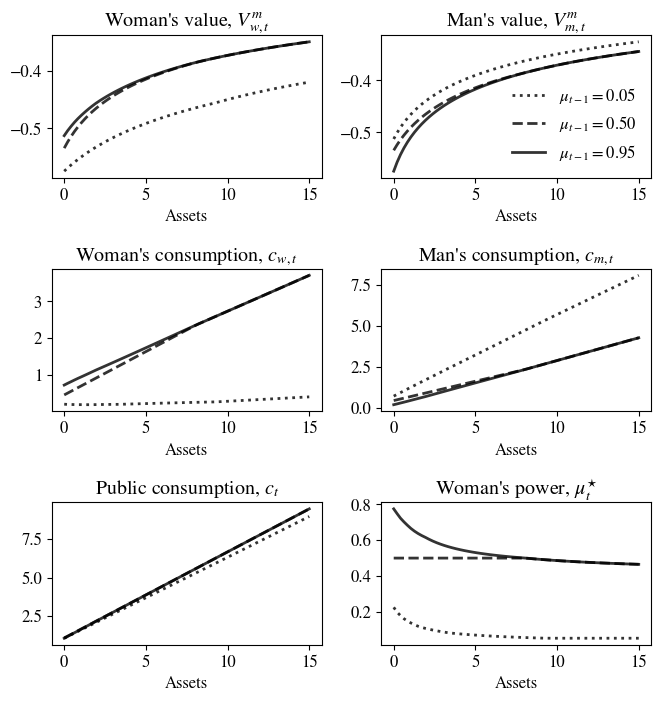

In [33]:
plotter.plot_using(plot_var_over_assets, models = models['Unequal Asset Split'], save_as='', colors=colors, linestyles=linestyles, y_grid = y_grid, subplot_legends=1, subplot_settings={'alpha':0.8})


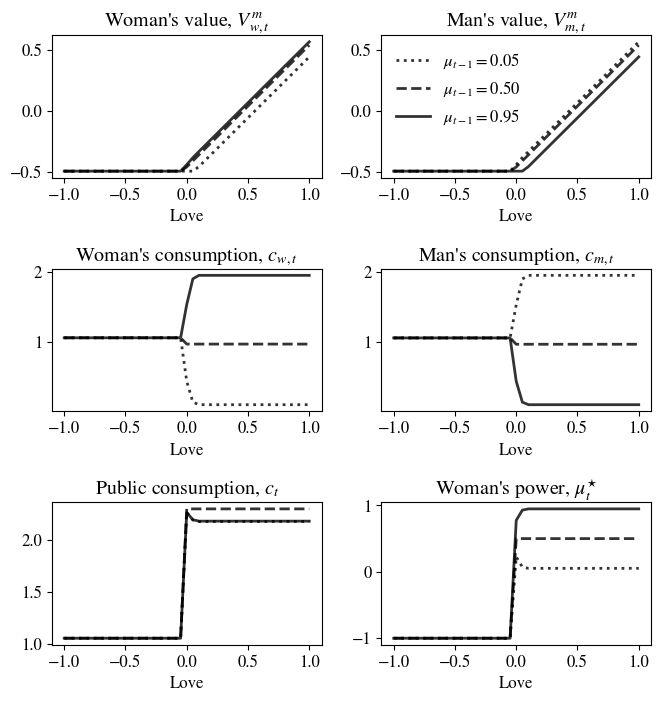

In [34]:
plotter.plot_using(plot_var_over_love, models = models['Baseline'], save_as='', colors=colors, linestyles=linestyles, y_grid = y_grid, subplot_legends=1, subplot_settings={'alpha':0.8})

## Simulation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['#A7002A', '#278094', '#FBBA1D', '#56882D', '#0C2C4D']


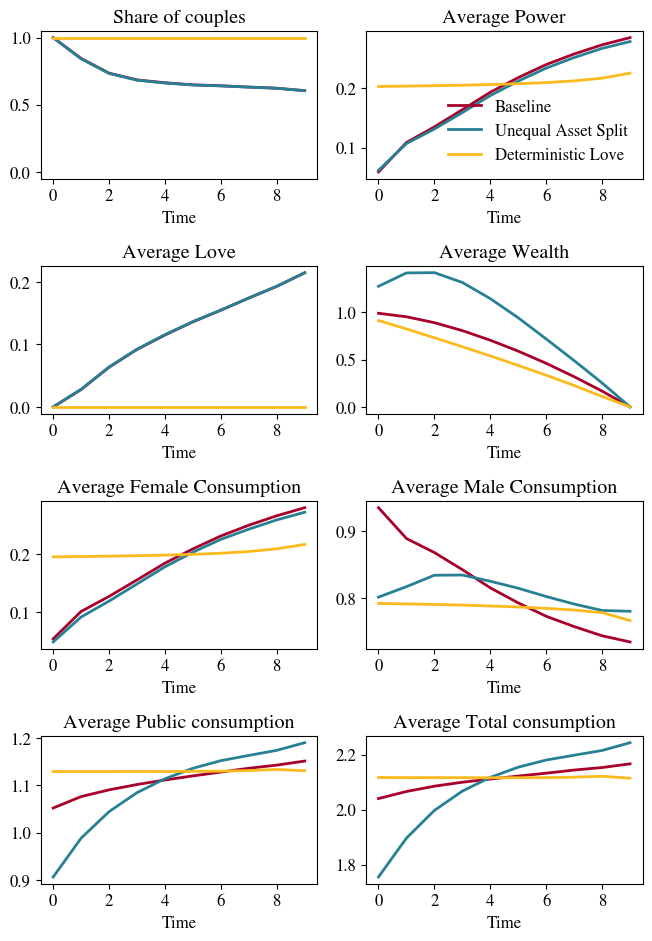

In [35]:
# Choose variables
variables = {"Share of couples" : 'couple',
             "Average Power" : 'power',
             "Average Love" : 'love',
             "Average Wealth" : 'A',
             "Average Female Consumption" : 'Cw_priv',
             "Average Male Consumption" : 'Cm_priv',
             "Average Public consumption" : 'Cw_pub',
             "Average Total consumption" : 'C_tot'}

# Set mean for couples
mask = models[model_names[0]].sim.couple==1
nans = np.nan + np.ones(models[model_names[0]].sim.couple.shape)
nans[models[model_names[0]].sim.couple==1] = 0.0

#and (models[model_names[1]].sim.power<np.percentile(models[model_names[1]].sim.power, 50)) 
#and (models[model_names[1]].sim.love<np.percentile(models[model_names[1]].sim.love, 50)) and (models[model_names[1]].sim.A<np.percentile(models[model_names[1]].sim.A, 10))
# funcs = {'mean': lambda x: np.nanmean(x, axis=0, where=mask),}
funcs = {'mean': lambda x: np.nanmean(x, axis=0),}

y_grid = [None]*8
y_grid[4:7] = [(0.437, 0.483)]*2 + [(1.077, 1.102)]
y_grid=None

# Plot
plotter = ModelPlot('variables', models, variables, funcs, size='A4')

fig = plotter.plot_using(plot_simulated, subplot_legends=1, y_grid=y_grid)

# get axes
ax = fig.get_axes()
# remove all curves in axes[0]
ax[0].clear()
# Get colors
colors = list(plotter.color_palette.values())
print(colors)
for i, m in enumerate(list(models.values())):
    ax[0] = plot_simulated(m, 'couple', lambda x: np.nanmean(x, axis=0), ax=ax[0], title=list(variables.keys())[0], color=colors[i], y_grid=(-0.05,1.05), subsample='all')
# ax[0] = plot_simulated(models['Baseline'], 'couple', lambda x: np.nanmean(x, axis=0), ax=ax[0], title=list(variables.keys())[0])
ax[0].legend().remove()

fig

In [36]:
model = models['Deterministic Love']
model.par.grid_A

array([ 0.        ,  0.20743191,  0.41668806,  0.62781736,  0.84087108,
        1.05590292,  1.27296924,  1.49212925,  1.71344518,  1.93698255,
        2.16281041,  2.39100161,  2.62163311,  2.85478635,  3.09054759,
        3.32900837,  3.57026594,  3.81442384,  4.06159249,  4.31188983,
        4.56544212,  4.82238481,  5.08286349,  5.34703511,  5.6150692 ,
        5.88714948,  6.16347557,  6.44426507,  6.72975603,  7.02020986,
        7.31591472,  7.61718981,  7.92439033,  8.2379138 ,  8.55820774,
        8.8857794 ,  9.22120814,  9.56516135,  9.91841551, 10.28188436,
       10.6566576 , 11.04405554, 11.44570871, 11.86367877, 12.30065133,
       12.76026399, 13.24771485, 13.77103975, 14.34436998, 15.        ])

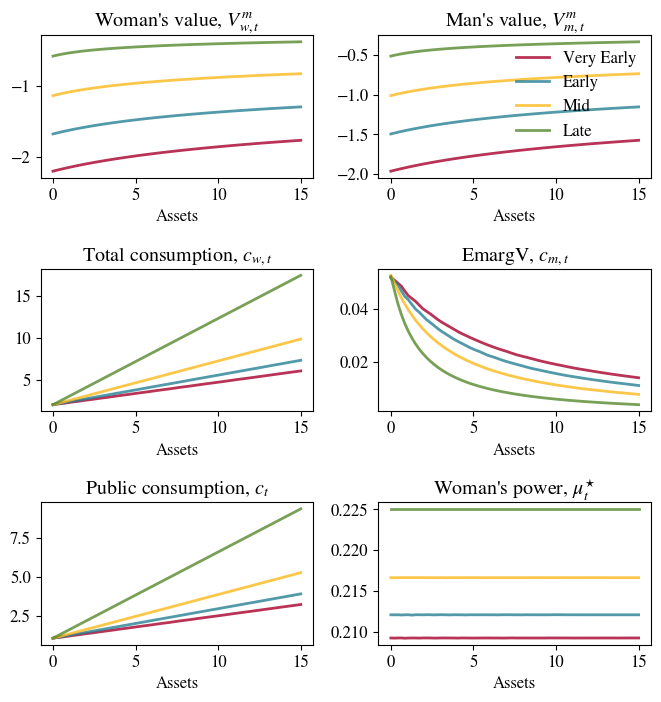

In [37]:
# Choose model

# Choose variables
variables = {r"Woman's value, $V_{w,t}^{m}$"        : "Vw_start_as_couple",
             r"Man's value, $V_{m,t}^{m}$"          : "Vm_start_as_couple", 
             r"Total consumption, $c_{w,t}$"  : "C_tot_start_as_couple", 
             r"EmargV, $c_{m,t}$"    : "EmargV_start_as_couple", 
             r"Public consumption, $c_{t}$"   : "C_pub_start_as_couple", 
             r"Woman's power, $\mu_t^{\star}$"        : "power"}

t, iP, iL, iA = [8, 1, 20, 2]

indxs = {
    'Very Early': (t-2,iP,iL,iA),
    'Early': (t-1,iP,iL,iA),
    'Mid': (t,iP,iL,iA),
    'Late': (t+1,iP,iL,iA),

}

# Plot
x_grid = None # (0,1)
y_grid = [None]*6
# y_grid[2:3] = [(2.,2.5), (0.04, 0.055)]
markers = ''
plotter = ModelPlot('variables', models, variables, indxs, size='A4')
plotter.plot_using(plot_var_over_assets, models = models['Deterministic Love'], subplot_legends=1, markers = markers, y_grid=y_grid, x_grid = x_grid, subplot_settings={'alpha':0.8})

In [38]:
stop

NameError: name 'stop' is not defined

In [ ]:
np.where(np.isclose(models['Unequal Asset Split'].sim.power[:,1],0, atol=1e-1
                    ))

In [ ]:
model = models['Unequal Asset Split']
i = 1
t = 1
print('couple: ', model.sim.couple[i,t])
print('power: ', model.sim.power[i,t])
print('love: ', model.sim.love[i,t])


In [ ]:
set(model.sim.power[:,9])

In [ ]:
# make histogram of power
t = 9

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.hist(models['Unequal Asset Split'].sim.power[:,t][models['Unequal Asset Split'].sim.couple[:,t]==1], bins=100, alpha=0.5, label='Unequal Asset Split');

In [ ]:
model = models['Unequal Asset Split']
model.sim.love

## Investigation

In [ ]:
# model_plot(models, plot_surplus, [''], idx1, shared_legend=True, subtitles=model_names)

In [ ]:
# t = 30
# iL = 20
# iAm = 15
# model = models['Model 2']
# var = models['Model 2'].sol.initial_power_idx[t,iL,:,iAm]

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(model.par.grid_Aw, model.par.grid_power[var])

# print(model.par.grid_Aw[iAm] / model.par.grid_Am[iAm])

# Sw = model.sol.Vw_single_to_couple[t,:,iL,iAm] - model.sol.Vw_single_to_single[t,iAm]
# Sm = model.sol.Vm_single_to_couple[t,:,iL,iAm] - model.sol.Vm_single_to_single[t,iAm]
# singlew = model.sol.Vw_single_to_single[t,iAm] * np.ones(model.par.num_power)
# singlem = model.sol.Vm_single_to_single[t,iAm] * np.ones(model.par.num_power)
# couplew = model.sol.Vw_single_to_couple[t,:,iL,iAm]
# couplem = model.sol.Vm_single_to_couple[t,:,iL,iAm]
# nash = Sw*Sm

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(model.par.grid_power, Sw, color='red')
# ax.plot(model.par.grid_power, Sm, color='blue')
# ax.plot(model.par.grid_power, nash, color='green')

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(model.par.grid_power, singlew, color='red')
# ax.plot(model.par.grid_power, singlem, color='blue')
# ax.plot(model.par.grid_power, couplew, color='red' , linestyle='--')
# ax.plot(model.par.grid_power, couplem, color='blue', linestyle='--')

In [ ]:
# Choose model
model = models['Unequal Asset Split']
model12 = list(models.values())[:2]
indx = (0, 10, 39, 2)

# Choose variables
variables = ['Vw_start_as_couple', 'Vm_start_as_couple', 'Cw_priv_couple_to_couple', 'Cm_priv_couple_to_couple', 'Cw_priv_start_as_couple', 'Cm_priv_start_as_couple', 'C_pub_start_as_couple', 'power']
variables = ['EVw_start_as_single', 'EVm_start_as_single', 'power']

plotter = ModelPlot('variables', model12, variables, indx, size='A4')
plotter.plot_using(plot_var_over_assets, subplot_legends='shared')

In [ ]:
# plot EVw_start_as_single
fig = plt.figure()
ax = fig.add_subplot(111)
for i, m in enumerate(model12):
    ax.plot(m.par.grid_Aw, m.sol.EVw_start_as_single[0,:], label=f"{model_names[i]} woman")
    #ax.plot(m.par.grid_Am, m.sol.EVm_start_as_single[9,:], label=model_names[i])
ax.legend()